In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mt2 import mt2

In [2]:
import sys
import ROOT

Welcome to JupyROOT 6.28/04


In [3]:
ROOT.gSystem.Load("libDelphes")

0

In [4]:
ROOT.gSystem.Load("libDelphes")
try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
    # ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTask.h"')
    # ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootConfReader.h"')
except:
    pass

In [5]:
chain = ROOT.TChain("Delphes")
# chain.Add('/home/dwkang/Projects/KPS_tuto/data/pp2tt2l_1k_delphes.root')
chain.Add('/home/dwkang/Projects/KPS_tuto/data/pp2tt2l_10k_delphes.root')

1

In [6]:
treeReader = ROOT.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

In [7]:
branchJet = treeReader.UseBranch("Jet")
branchElectron = treeReader.UseBranch("Electron")
branchMuon = treeReader.UseBranch("Muon")
branchMET= treeReader.UseBranch("MissingET")
branchParticle = treeReader.UseBranch("Particle")

In [8]:
JetPT=[]
mass=[]
for entry in range(0, numberOfEntries):
    # Load selected branches with data from specified event
    treeReader.ReadEntry(entry)

    # If event contains at least 1 jet
    if branchJet.GetEntries() > 0:
        # Take first jet
        jet = branchJet.At(0)
        # print(jet.PT)

        # Plot jet transverse momentum
        JetPT.append(jet.PT)
    
    # If event contains at lesast 2 electrons
    if branchElectron.GetEntries() > 1:
        # Take first two electrons
        elec1 = branchElectron.At(0)
        elec2 = branchElectron.At(1)
        m_ee = (elec1.P4()+elec2.P4()).M()
        # print(m_ee)
        # Plot their invariant mass
        mass.append( m_ee )

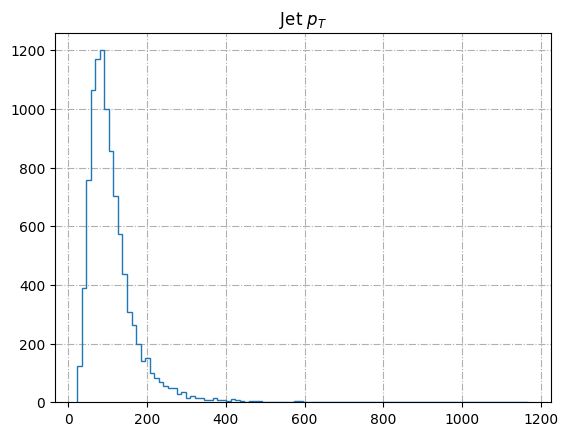

In [9]:
fig, ax = plt.subplots()
ax.hist(JetPT, bins=100, histtype='step', density=False)
ax.grid(True, linestyle='-.')
ax.set_title('Jet $p_{T}$')
plt.show()

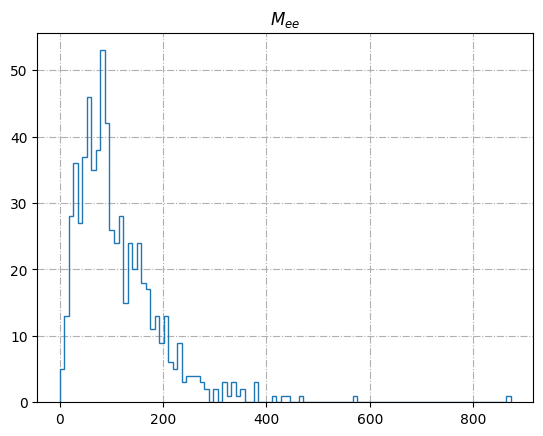

In [10]:
fig, ax = plt.subplots()
ax.hist(mass, bins=100, histtype='step', density=False)
ax.grid(True, linestyle='-.')
ax.set_title('$M_{ee}$')
plt.show()

In [11]:
from mt2 import mt2


In [12]:
ptlcut = 25
etalcut = 2.5
ptjcut = 25
etajcut = 2.5
metcut = 35
mtcut = 60
mll_mzcut = 10
mllcut = 15
htcut = 130
MZ = 91.2
# ptlcut = 0
# etalcut = 5
# ptjcut = 0
# etajcut = 5
# metcut = 0
# mtcut = 0
# mll_mzcut = 0
# mllcut = 0
# htcut = 0

In [13]:
# Counters
SR = 0
hist_mt2_tt=[]
hist_mt2_ww=[]
hist_mt2_ll=[]

# Looping event entries
for entry in range(0, numberOfEntries):
    treeReader.ReadEntry(entry)
    
    # Initialize the objects
    electronColl = []
    muonColl = []
    jetColl = []
    bjetColl = []
    taujetColl = []
    untagjetColl = []
    
    lepCharge = 0.0
    # for electron
    numberOfElectrons = branchElectron.GetEntriesFast()
    for i in range(0, numberOfElectrons):
        tmpelectron = branchElectron.At(i)
        if tmpelectron.PT > ptlcut and abs(tmpelectron.Eta) < etalcut:
            electronColl.append(tmpelectron)
            lepCharge = lepCharge + tmpelectron.Charge
            
    # for muon
    numberOfMuons = branchMuon.GetEntriesFast()
    for i in range(0, numberOfMuons):
        tmpmuon = branchMuon.At(i)
        if tmpmuon.PT > ptlcut and abs(tmpmuon.Eta) < etalcut:
            muonColl.append(tmpmuon)
            lepCharge = lepCharge + tmpmuon.Charge
    
    # for jets
    Htjet = 0.0
    numberOfJets = branchJet.GetEntriesFast()
    for i in range(0, numberOfJets):
        tmpjet = branchJet.At(i)
        if tmpjet.PT > ptjcut and abs(tmpjet.Eta) < etajcut:
            Htjet = Htjet + tmpjet.PT
            untagjetColl.append(tmpjet) # un-tagged jet storing
            if tmpjet.BTag:
                bjetColl.append(tmpjet) # b-jet storing
            elif tmpjet.TauTag:
                taujetColl.append(tmpjet) # tau-jet sotring
            else:
                jetColl.append(tmpjet) # ordinary-jet storing
    
    # for missing transverse energy
    met = branchMET.At(0)
    
    lepton_pass = False
    jet_pass = False
    met_pass = False
    
    # Lepton Criteria
    if len(electronColl) + len(muonColl) == 2:
        if lepCharge!=0:
            continue
        if len(electronColl) == 2:
            if electronColl[0].Charge < 0:
                lepton1 = electronColl[0].P4()
                lepton2 = electronColl[1].P4()
            else:
                lepton1 = electronColl[1].P4()
                lepton2 = electronColl[0].P4()
            if (lepton1 + lepton2).M() <= mllcut:
                continue
            if abs((lepton1+lepton2).M() - MZ) <= mll_mzcut:
                continue
            if met.MET <= metcut:
                continue
            lepton_pass = True
        elif len(electronColl) == 1:
            if electronColl[0].Charge < 0:
                lepton1 = electronColl[0].P4()
                lepton2 = muonColl[0].P4()
            else:
                lepton1 = muonColl[0].P4()
                lepton2 = electronColl[0].P4()
            if Htjet+lepton1.Pt()+lepton2.Pt() <= htcut:
                continue
            lepton_pass = True
        else:
            if muonColl[0].Charge <0:
                lepton1 = muonColl[0].P4()
                lepton2 = muonColl[1].P4()
            else:
                lepton1 = muonColl[1].P4()
                lepton2 = muonColl[0].P4()
            if (lepton1 + lepton2).M() <= mllcut:
                continue
            if abs((lepton1+lepton2).M() - MZ) <= mll_mzcut:
                continue
            if met.MET <= metcut:
                continue
            lepton_pass = True
    else:
        lepton_pass = False
    
    # MET Criteria
    if met.MET > metcut:
        met_pass = True
    
    # Jet Criteria
    if len(bjetColl) >= 2:
        jet_pass = True
        bjet1 = bjetColl[0].P4()
        bjet2 = bjetColl[1].P4()
    
    # Start Checking
    if lepton_pass and met_pass and jet_pass:
        SR = SR + 1
        
        # Set MET info
        
        # b1l1 = bjet1+lepton1
        # b2l2 = bjet2+lepton2
        # b1l2 = bjet1+lepton2
        # b2l1 = bjet2+lepton1
        # if b1l1.M() < 153.39 and b2l2.M() < 153.39:
        #     if b2l1.M() > 153.39 or b1l2.M() >153.39:
        #         bl1 = b1l1
        #         bl2 = b2l2
        # elif b1l2.M() < 153.39 and b2l1.M() < 153.39:
        #     if b2l2.M() > 153.39 or b2l2.M() >153.39:
        #         bl1 = b1l2
        #         bl2 = b2l1
        # else:
        #     bl1 = b1l1
        #     bl2 = b2l2
        bl1 = bjet1+lepton1
        bl2 = bjet2+lepton2

        met_w = met.P4()+lepton1+lepton2
        mt2_tt = mt2( bl1.M(), bl1.Px(), bl1.Py(),
                      bl2.M(), bl2.Px(), bl2.Py(),
                     met.P4().Px(), met.P4().Py(),
                    0, 0)
        hist_mt2_tt.append(mt2_tt)

        mt2_ll = mt2( lepton1.M(), lepton1.Px(), lepton1.Py(),
                      lepton2.M(), lepton2.Px(), lepton2.Py(),
                     met.P4().Px(), met.P4().Py(),
                    0, 0)
        hist_mt2_ll.append(mt2_ll)

        mt2_ww = mt2( bjet1.M(), bjet1.Px(), bjet1.Py(),
                      bjet2.M(), bjet2.Px(), bjet2.Py(),
                     met_w.Px(), met_w.Py(),
                    80, 80)
        hist_mt2_ww.append(mt2_ww)

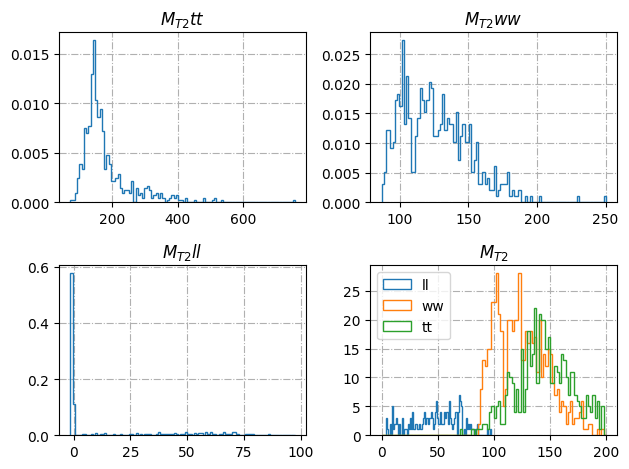

In [14]:
hist_mt2_tt=np.array(hist_mt2_tt)
hist_mt2_ww=np.array(hist_mt2_ww)
hist_mt2_ll=np.array(hist_mt2_ll)

fig, ax = plt.subplots(2,2)
ax[0,0].hist(hist_mt2_tt, bins=100, histtype='step', density=True)
ax[0,0].grid(True, linestyle='-.')
ax[0,0].set_title('$M_{T2} tt$')

ax[0,1].hist(hist_mt2_ww, bins=100, histtype='step', density=True)
ax[0,1].grid(True, linestyle='-.')
ax[0,1].set_title('$M_{T2} ww$')

ax[1,0].hist(hist_mt2_ll, bins=100, histtype='step', density=True)
ax[1,0].grid(True, linestyle='-.')
ax[1,0].set_title('$M_{T2} ll$')

ax[1,1].hist(hist_mt2_ll[hist_mt2_ll>1], bins=100, histtype='step', density=False, label='ll')
ax[1,1].hist(hist_mt2_ww[hist_mt2_ww>1], bins=100, histtype='step', density=False, range=(0,200), label='ww')
ax[1,1].hist(hist_mt2_tt, bins=100, histtype='step', density=False, range=(0,200), label='tt')
ax[1,1].grid(True, linestyle='-.')
ax[1,1].legend()
ax[1,1].set_title('$M_{T2}$')

fig.tight_layout()
plt.show()

In [15]:
SR

604